In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
filename = "HSI.csv"
df = pd.read_csv(filename)

In [3]:
df['Date'] =  pd.to_datetime(df['Time'], unit='s')
df.set_axis(df['Date'], inplace=True)
df.drop(columns=['Open', 'High', 'Low', 'AdjClose','Time'], inplace=True)
print(df)

                   Close       Date
Date                               
1993-12-10  10228.099610 1993-12-10
1993-12-13  10248.599610 1993-12-13
1993-12-14  10021.500000 1993-12-14
1993-12-15   9945.299805 1993-12-15
1993-12-16  10339.700200 1993-12-16
...                  ...        ...
2020-03-30  23175.109380 2020-03-30
2020-03-31  23603.480470 2020-03-31
2020-04-01  23085.789060 2020-04-01
2020-04-02  23280.060550 2020-04-02
2020-04-03  23236.109380 2020-04-03

[6489 rows x 2 columns]


In [4]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

5191
1298


In [5]:
look_back = 7

train_generator = TimeseriesGenerator(close_train, close_train, sampling_rate=1,stride=1, length=look_back, batch_size=15)     
test_generator = TimeseriesGenerator(close_test, close_test, sampling_rate=1,stride=1, length=look_back, batch_size=1)

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(150,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
history =  model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/25
346/346 [==============================] - 4s 12ms/step - loss: 12364719.0107
Epoch 2/25
346/346 [==============================] - 3s 9ms/step - loss: 264863.0165
Epoch 3/25
346/346 [==============================] - 4s 10ms/step - loss: 276460.6480
Epoch 4/25
346/346 [==============================] - ETA: 0s - loss: 312790.63 - 3s 8ms/step - loss: 312094.8472
Epoch 5/25
346/346 [==============================] - 3s 8ms/step - loss: 297328.1682
Epoch 6/25
346/346 [==============================] - 2s 7ms/step - loss: 369369.1912
Epoch 7/25
346/346 [==============================] - 3s 7ms/step - loss: 271781.1821
Epoch 8/25
346/346 [==============================] - 3s 7ms/step - loss: 280426.2920
Epoch 9/25
346/346 [==============================] - 3s 10ms/step - loss: 260499.4720
Epoch 10/25
346/346 [==============================] - 3s 10ms/step - loss: 288209.3298
Epoch 11/25
346/346 [==============================] - 3s 8ms/step - loss: 289375.8201
Epoch 12/25
346/34

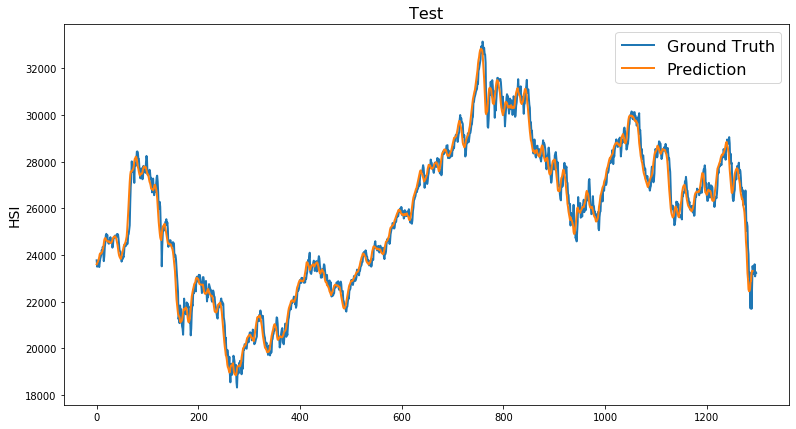

In [7]:
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(close_test, label='Ground Truth', linewidth=2)
ax.plot(prediction, label='Prediction', linewidth=2)
ax.set_ylabel('HSI', fontsize=14)
ax.set_title('Test', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [8]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 7
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [9]:
dfForecast =  pd.DataFrame(data=forecast,index=forecast_dates)
dfForecast.index.name = "Time"
dfForecast.columns = ['Close']
dfForecast

,Close
Time,
2020-04-03,23236.109380
2020-04-04,23296.673828
2020-04-05,23268.169922
2020-04-06,23275.957031
2020-04-07,23228.156250
2020-04-08,23235.572266
2020-04-09,23236.500000
2020-04-10,23236.654297


In [10]:
def line_plot(line1, label1=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.set_ylabel('HSI', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    

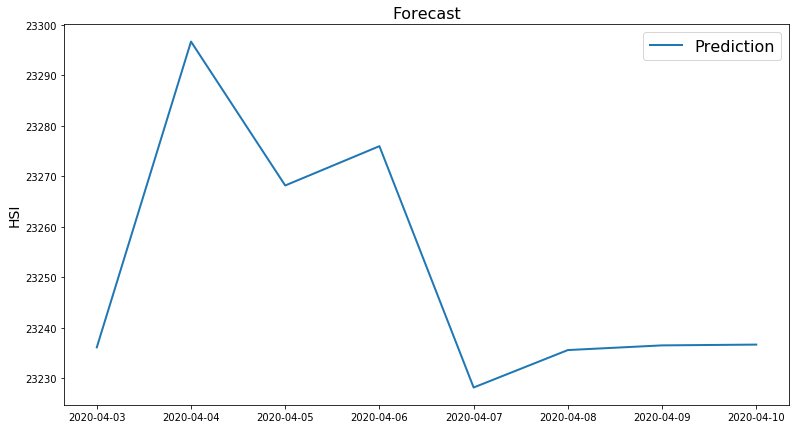

In [11]:
line_plot(dfForecast['Close'], label1='Prediction', title='Forecast', lw=2)